Inspired by [blog link](https://medium.com/mcd-unison/whatsapp-group-chat-analysis-with-python-3f5196280ba)

In [1]:
import re
import regex
import pandas as pd
import numpy as np
import emoji
import plotly.express as px
from collections import Counter
import nltk 
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

In [2]:
parsedData = [] 
counter=0

conversationPath = '/Users/vinay/Desktop/_chat.txt' 
with open(conversationPath, encoding="utf-8") as fp:
    fp.readline() 
    messageBuffer = [] 
    datetime, author = None, None
    while True:
        line = fp.readline()
        #print(line)
        if not line: 
            break
        #line = line.strip() 
        dt = line[:22].replace("[","").replace("]","")
        if 'AM' in line[22:25]:
            author = 'AM'
        else:
            author='VK'
        msg = line[26:].strip()
        if 'omitted' not in msg:
            parsedData.append([dt, author, msg]) 
        else:
            counter+=1
            

In [3]:
counter

98

In [4]:
chat = pd.DataFrame(parsedData, columns=['DateTime', 'Author', 'Message']) 

In [5]:
#column urlcount
URLPATTERN = r'(https?://\S+)'
chat['urlcount'] = chat.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()#column Letter_Count
chat['Letter_Count'] = chat['Message'].apply(lambda s : len(s))#column Word_Count
chat['Word_Count'] = chat['Message'].apply(lambda s : len(s.split(' ')))

In [6]:
def split_count(text):
    
    text = emoji.demojize(text)
    text = re.findall(r'(:[^:]*:)', text)
    list_emoji = [emoji.emojize(x) for x in text]
    return list_emoji

chat["emoji"] = chat["Message"].apply(split_count)

In [7]:
chat

DateTime Author                               Message  \
0     4/23/21, 10:18:58 PM     VK                                Ping !   
1     4/23/21, 10:19:04 PM     VK                            This is VK   
2     4/23/21, 10:20:49 PM     AM                           Oh hi VK! 😛   
3     4/23/21, 10:21:03 PM     AM            What’s your full name btw?   
4     4/23/21, 10:22:54 PM     VK                                Hellos   
...                    ...    ...                                   ...   
3316  4/30/21, 1:18:37 AM      AM  Okay! I will remind you tomorrow! 😛😛   
3317  4/30/21, 1:18:42 AM      AM                          What time? 🙈   
3318  4/30/21, 1:18:50 AM      VK                                 Hahha   
3319  4/30/21, 1:18:54 AM      VK                Morning should be good   
3320  4/30/21, 1:19:09 AM      AM                Cool! Morning it is! 😅   

      urlcount  Letter_Count  Word_Count   emoji  
0            0             6           2      []  
1            0            10           3      []  
2            0            11           4     [😛]  
3            0            26           5      []  
4            0             6           1      []  
...        ...           ...         ...     ...  
3316         0            36           7  [😛, 😛]  
3317         0            12           3     [🙈]  
3318         0             5           1      []  
3319         0            22           4      []  
3320         0            22           5     [😅]  

[3321 rows x 7 columns]

98 media mesages

In [8]:
total_messages = chat.shape[0]
media_messages = 98 #harcode
average_message_words = chat['Word_Count'].mean()
average_message_letters = chat['Letter_Count'].mean()

print('Total Messages ',total_messages)
print('Media Message', media_messages)
print('Average Words by Messages', round(average_message_words, 2))
print('Average Letters by Messages', round(average_message_letters, 2))
print('Average Message Per Day', round(total_messages/8, 2)) #harcode

Total Messages  3321
Media Message 98
Average Words by Messages 6.84
Average Letters by Messages 33.73
Average Message Per Day 415.12


VK    1876
AM    1445
Name: Author, dtype: int64

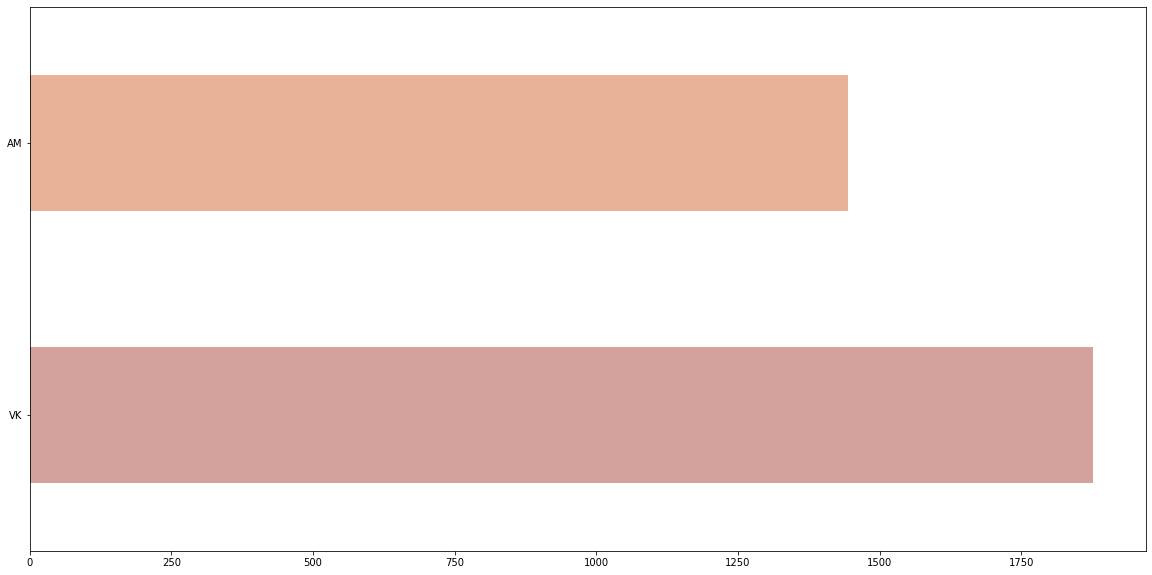

In [9]:
qty_message_author = chat['Author'].value_counts()
qty_message_author.plot(kind='barh',figsize=(20,10), color=['#D4A29C', '#E8B298'])
qty_message_author

Average messages per day


VK    234.500
AM    180.625
Name: Author, dtype: float64

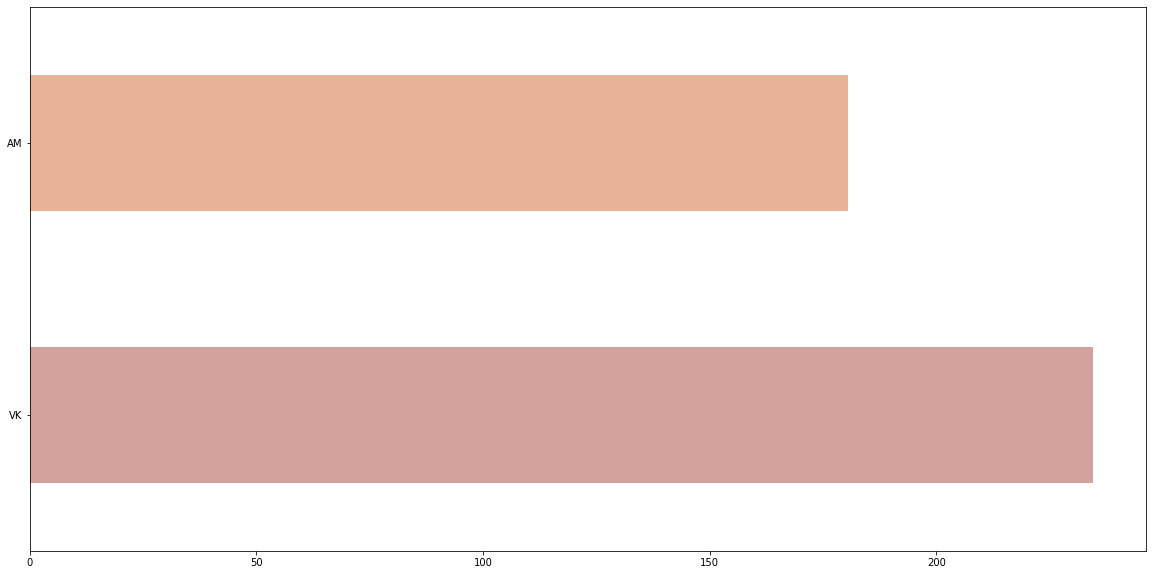

In [10]:
print("Average messages per day")
qty_message_author = chat['Author'].value_counts()/8
qty_message_author.plot(kind='barh',figsize=(20,10), color=['#D4A29C', '#E8B298'])
qty_message_author

In [11]:
def remove_emoji(text: str) -> str:
    text = emoji.demojize(text)
    text = re.sub(r'(:[^:]*:)', '', text)
    return text

In [12]:
commond_words = chat[['Author','Message']].copy()

from nltk.corpus import stopwords
STOPWORDS = stopwords.words('english')
stopwords = list(STOPWORDS)
stopwords = stopwords + ["?", "that’s", "i’m", "it’s"]

commond_words["Message"] = (commond_words["Message"]
                           .str.lower()
                           .str.split()
                           .apply(lambda x: [item for item in x if item not in stopwords])
                           .explode()
                           .reset_index(drop=True)
                 )

#commond_words['Message']= commond_words['Message'].apply(remove_emoji)
commond_words['Message']= commond_words['Message'].replace('nan', np.NaN)
commond_words['Message']= commond_words['Message'].replace('', np.NaN)


In [ ]:
words_dict = dict(Counter(commond_words.Message))
words_dict = sorted(words_dict.items(), key=lambda x: x[1], reverse=True)

words_dict = pd.DataFrame(words_dict, columns=['words', 'count'])

fig = px.bar(words_dict.head(25).dropna(), x='words', y='count',
                 labels={'words':'Common Words'}, 
                 height=400)
fig.update_traces(marker_color='#EDCC8B', marker_line_color='#D4A29C',
                  marker_line_width=1.5, opacity=0.6)
fig.update_layout(title_text='Commond Words Chart')
fig.show()

![alt text](images/common_words.png "Title")

In [ ]:
TopTen =5
author_commond_words =  (commond_words.set_index('Author')['Message']
                          .dropna()
                          .groupby(level=0)
                          .value_counts()
                          .groupby(level=0)
                          .head(TopTen)
                          .rename_axis(('Author','words'))
                          .reset_index(name='count'))

l = author_commond_words.Author.unique()
for i in range(len(l)):
    dummy_df = author_commond_words[author_commond_words['Author'] == l[i]]
    print(dummy_df)
    print('Most Commond Words by', l[i])
    fig = px.bar(dummy_df, x='words', y='count',
                 labels={'words':'Author Common Words'}, 
                 height=380)
    fig.update_traces(marker_color='#EDCC8B', marker_line_color='#D4A29C',
                  marker_line_width=1.5, opacity=0.6)
    fig.update_layout(title_text='Author Commond Words Chart')
    fig.show()

![alt text](images/am_top_words.png "Title")
![alt text](images/vk_top_words.png "Title")

In [13]:
#function to display wordcloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");
#function to remove urls from text
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

In [14]:
def word_cloud_from_df(chat):

    chat_word_cloud = chat[['Message']].copy()
    chat_word_cloud['Message']= chat_word_cloud['Message'].apply(remove_emoji)
    chat_word_cloud['Message']= chat_word_cloud['Message'].apply(remove_urls)
    chat_word_cloud['Message']= chat_word_cloud['Message'].replace('nan', np.NaN)
    chat_word_cloud['Message']= chat_word_cloud['Message'].replace('', np.NaN)
    chat_word_cloud['Message']= chat_word_cloud.Message.str.replace(r"(a|j)?(ja)+(a|j)?", "jaja")
    chat_word_cloud['Message']= chat_word_cloud.Message.str.replace(r"(a|j)?(jaja)+(a|j)?", "jaja")
    text = " ".join(review for review in chat_word_cloud.Message.dropna())
    wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, 
    background_color='black', colormap='Set2', collocations=False,
    stopwords = stopwords).generate(text)# Plot
    plot_cloud(wordcloud)

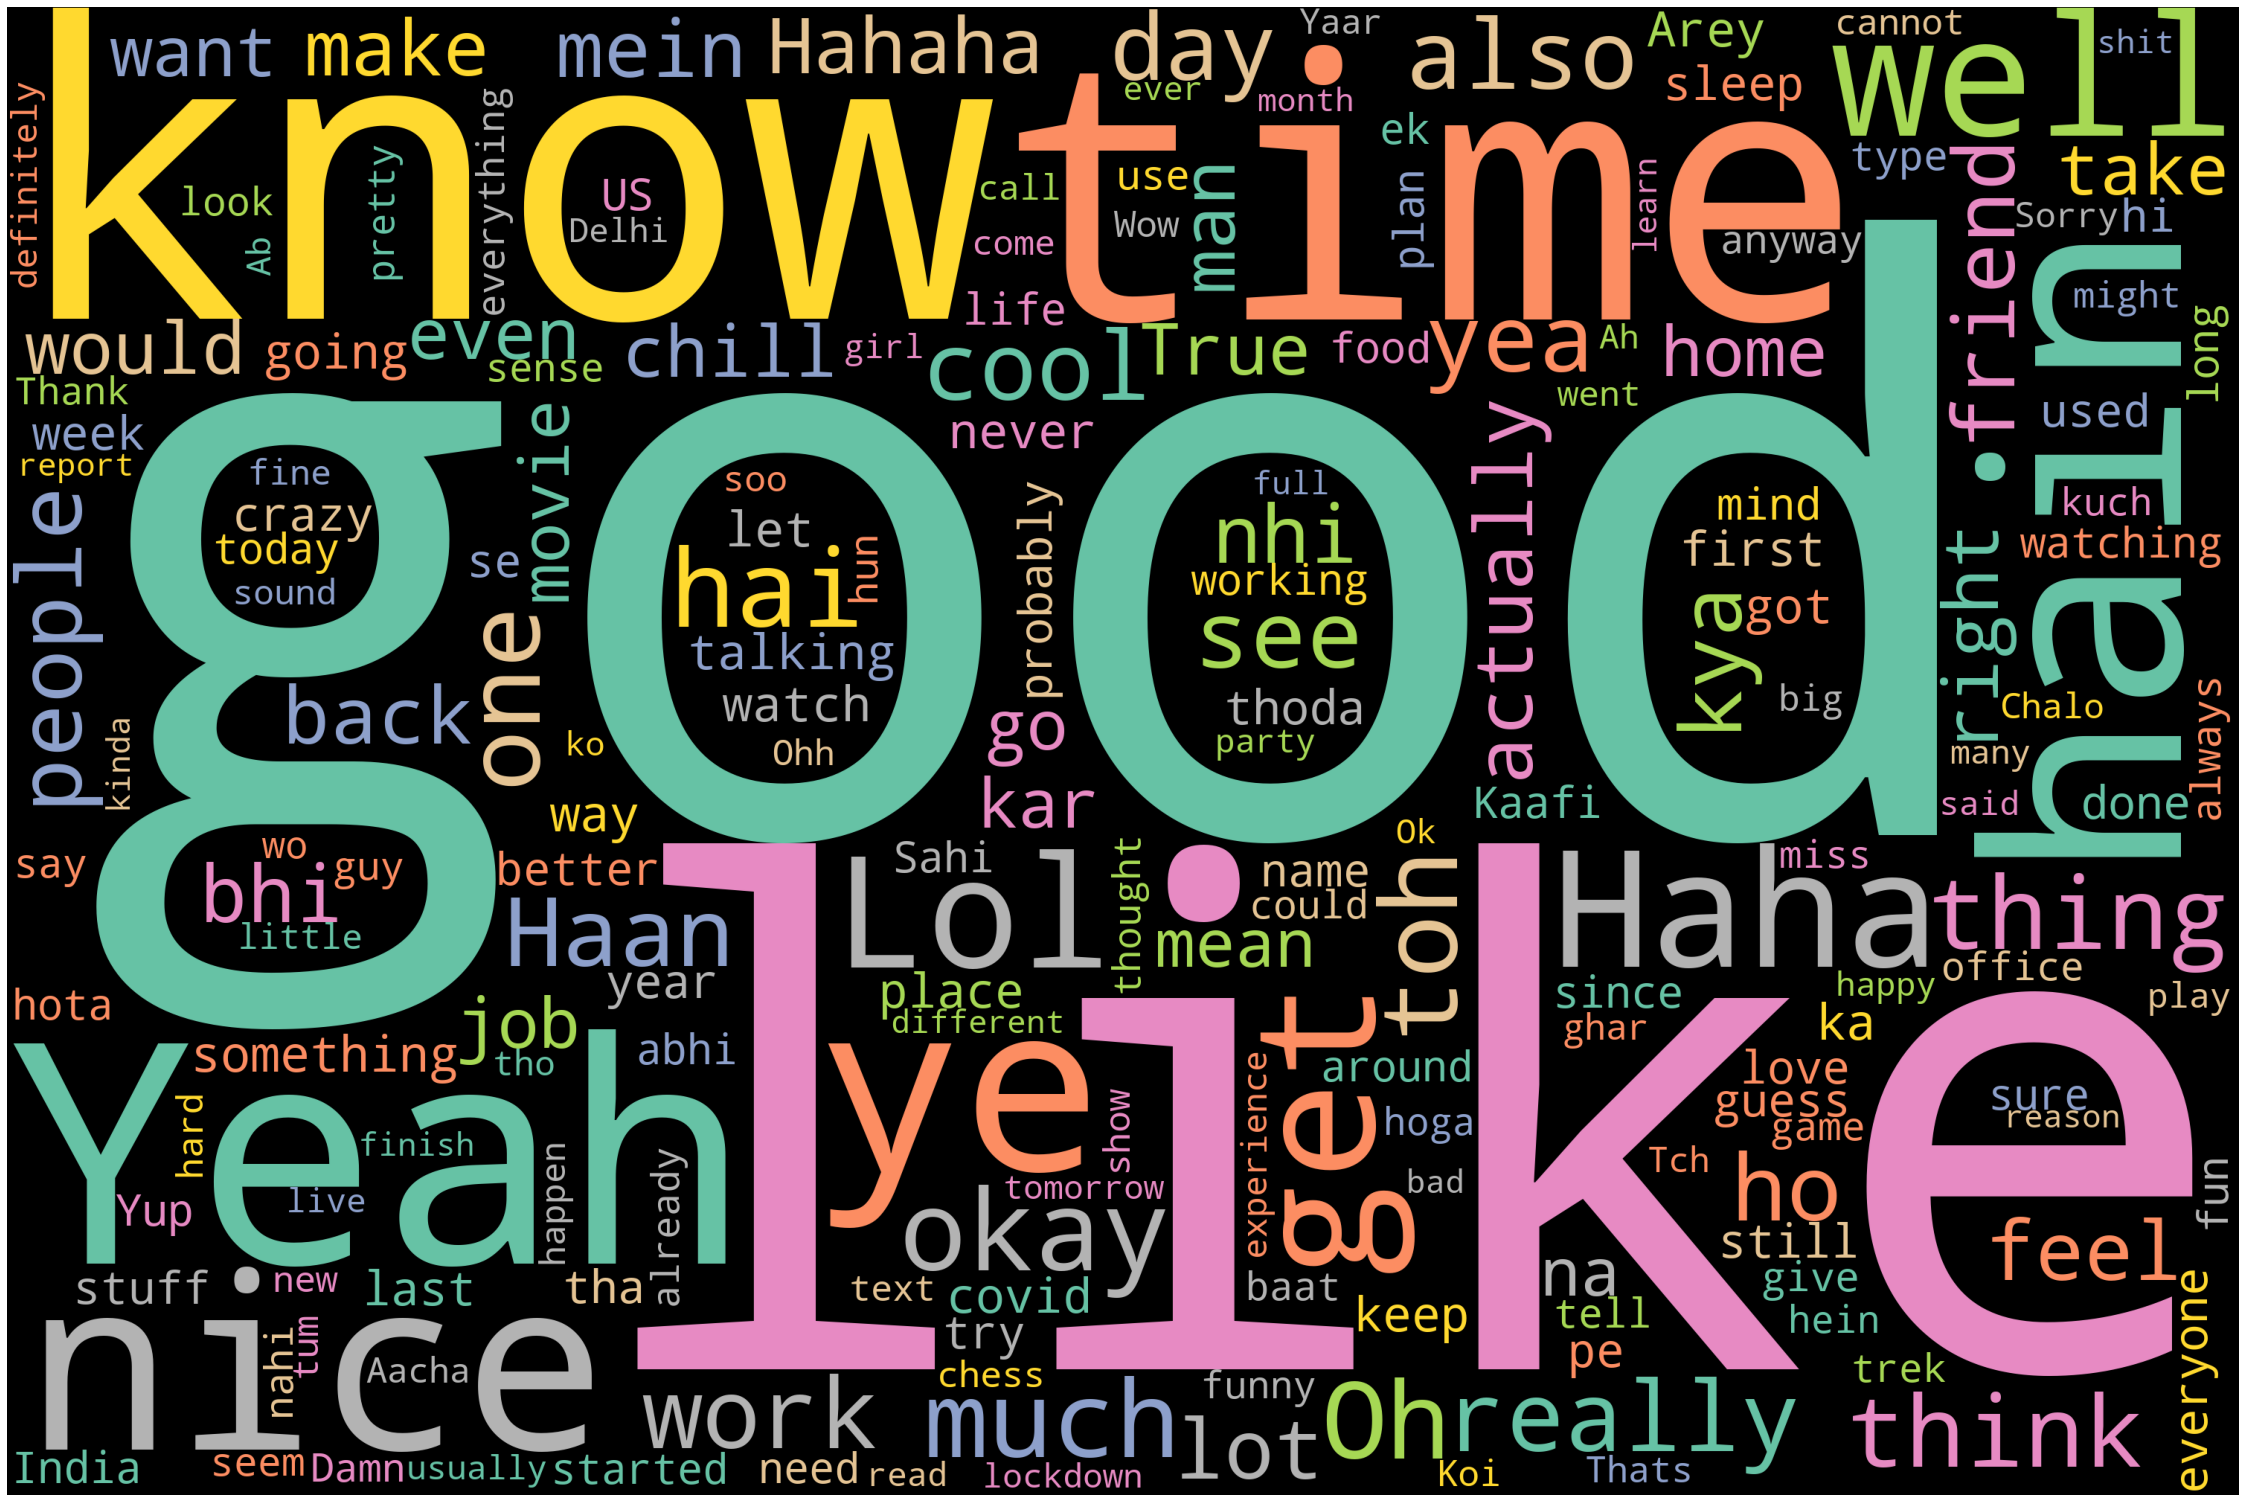

In [15]:
word_cloud_from_df(chat)

In [16]:
am_data = chat[chat['Author']=='AM']
vk_data = chat[chat['Author']=='VK']

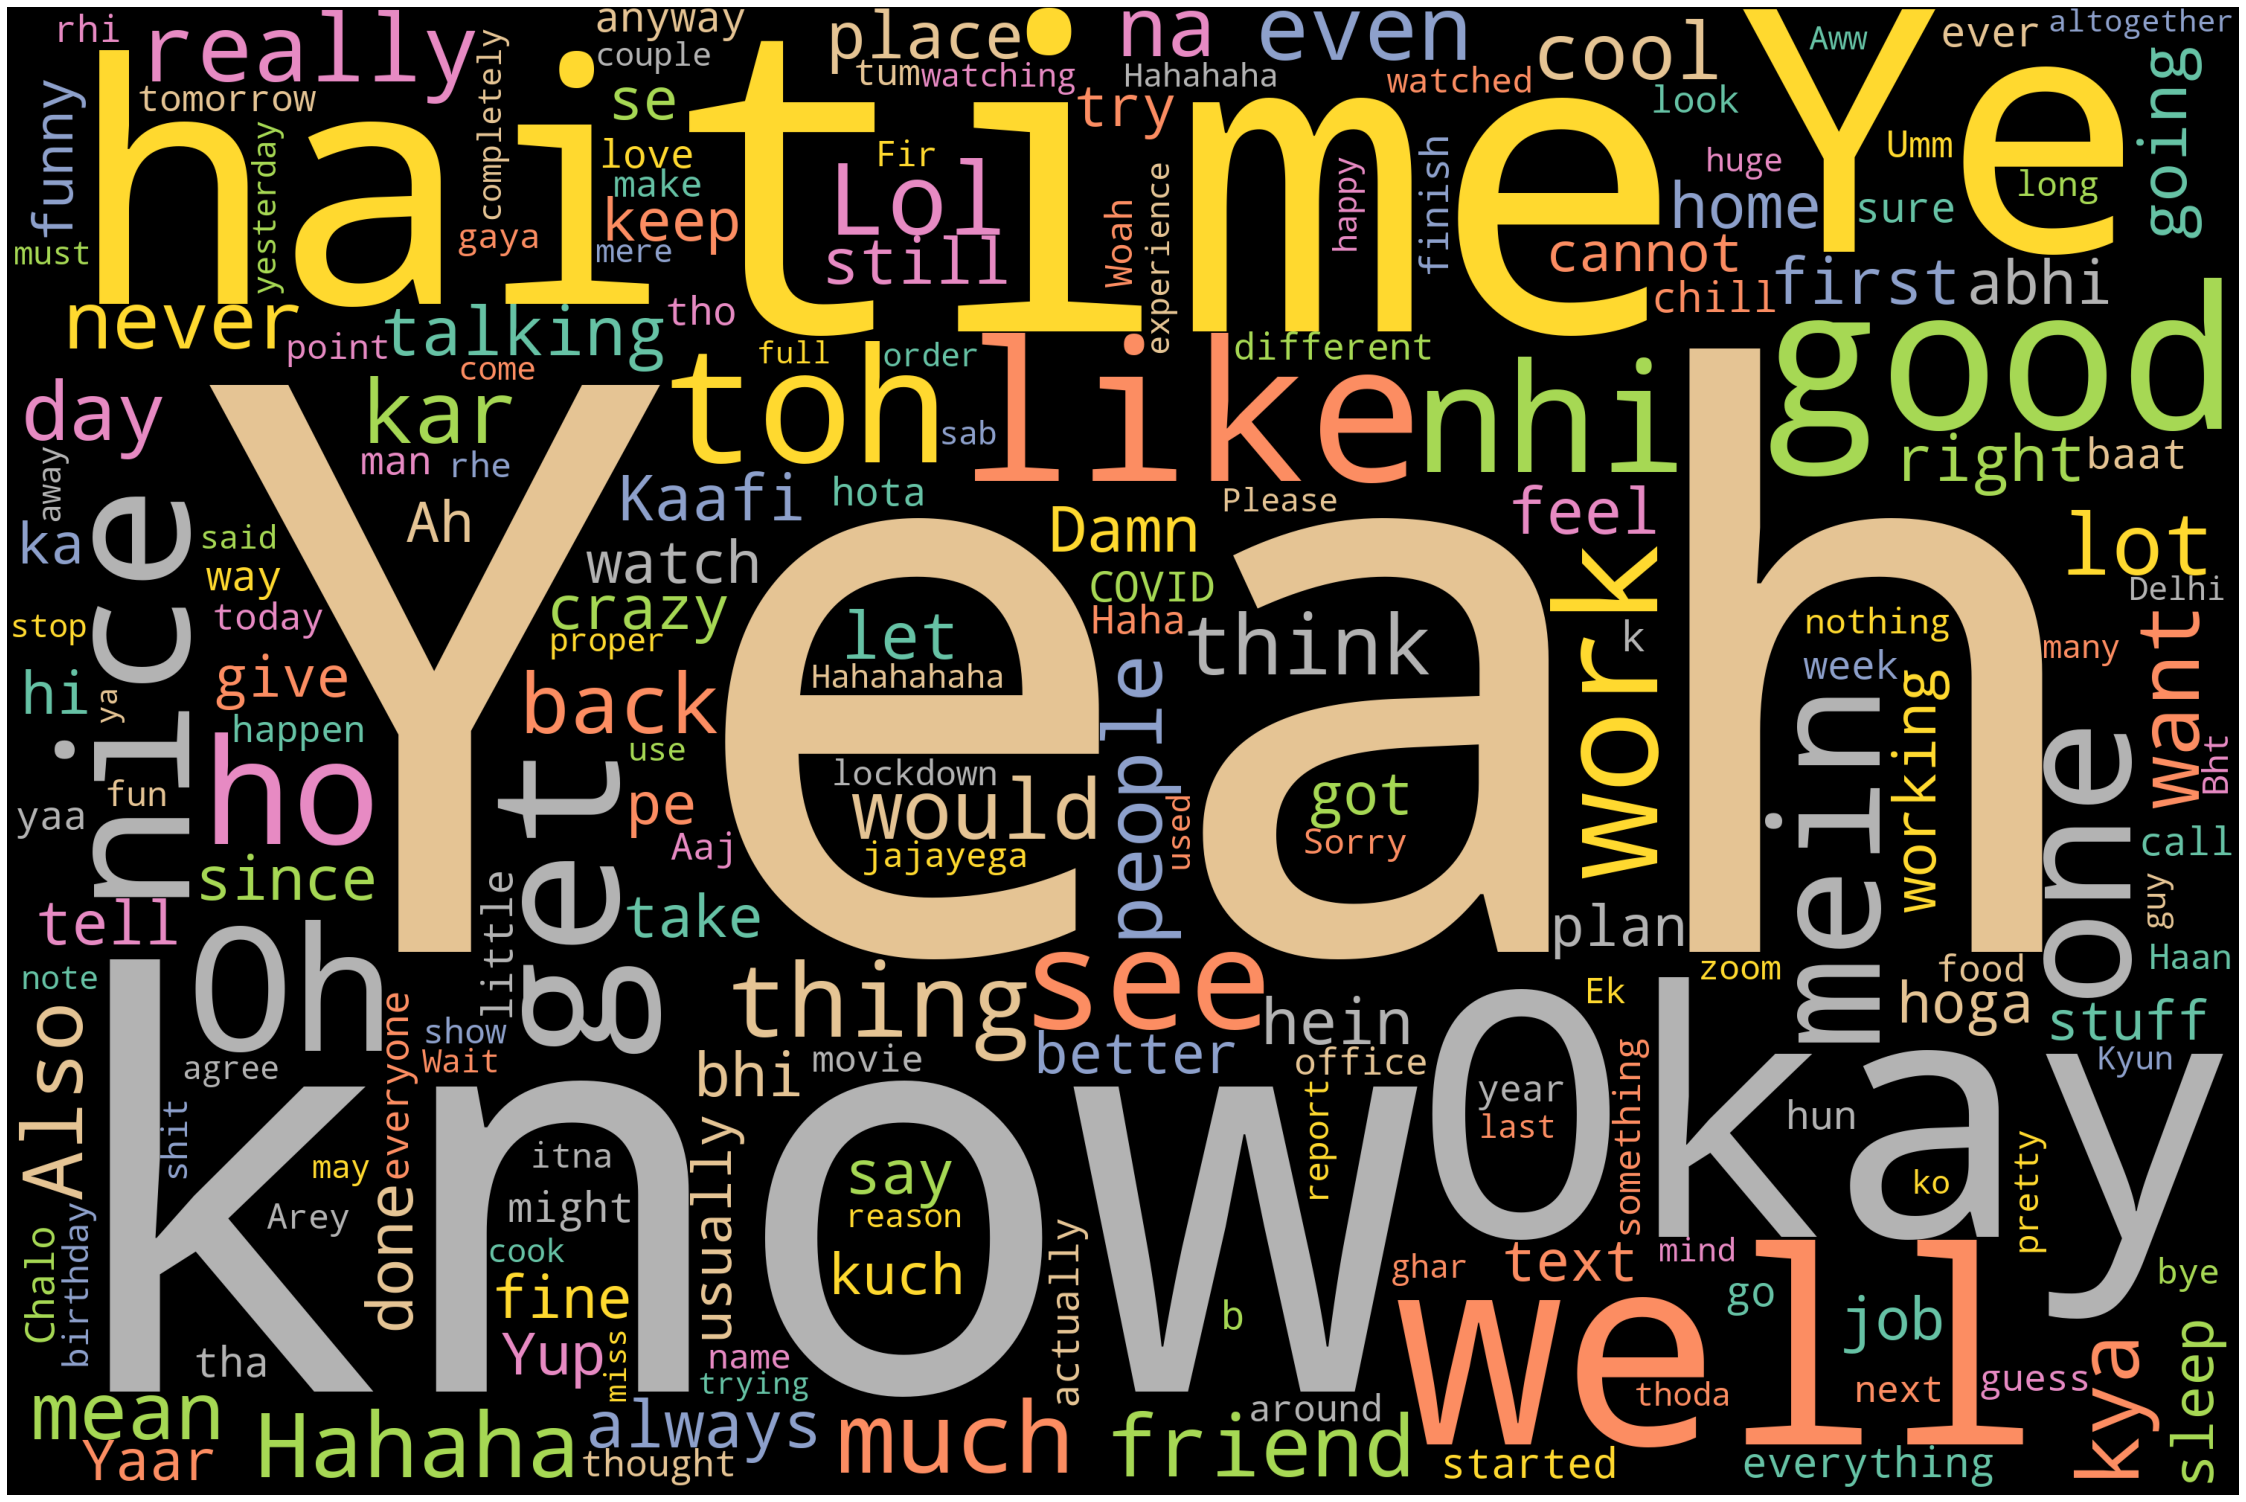

In [17]:
word_cloud_from_df(am_data)

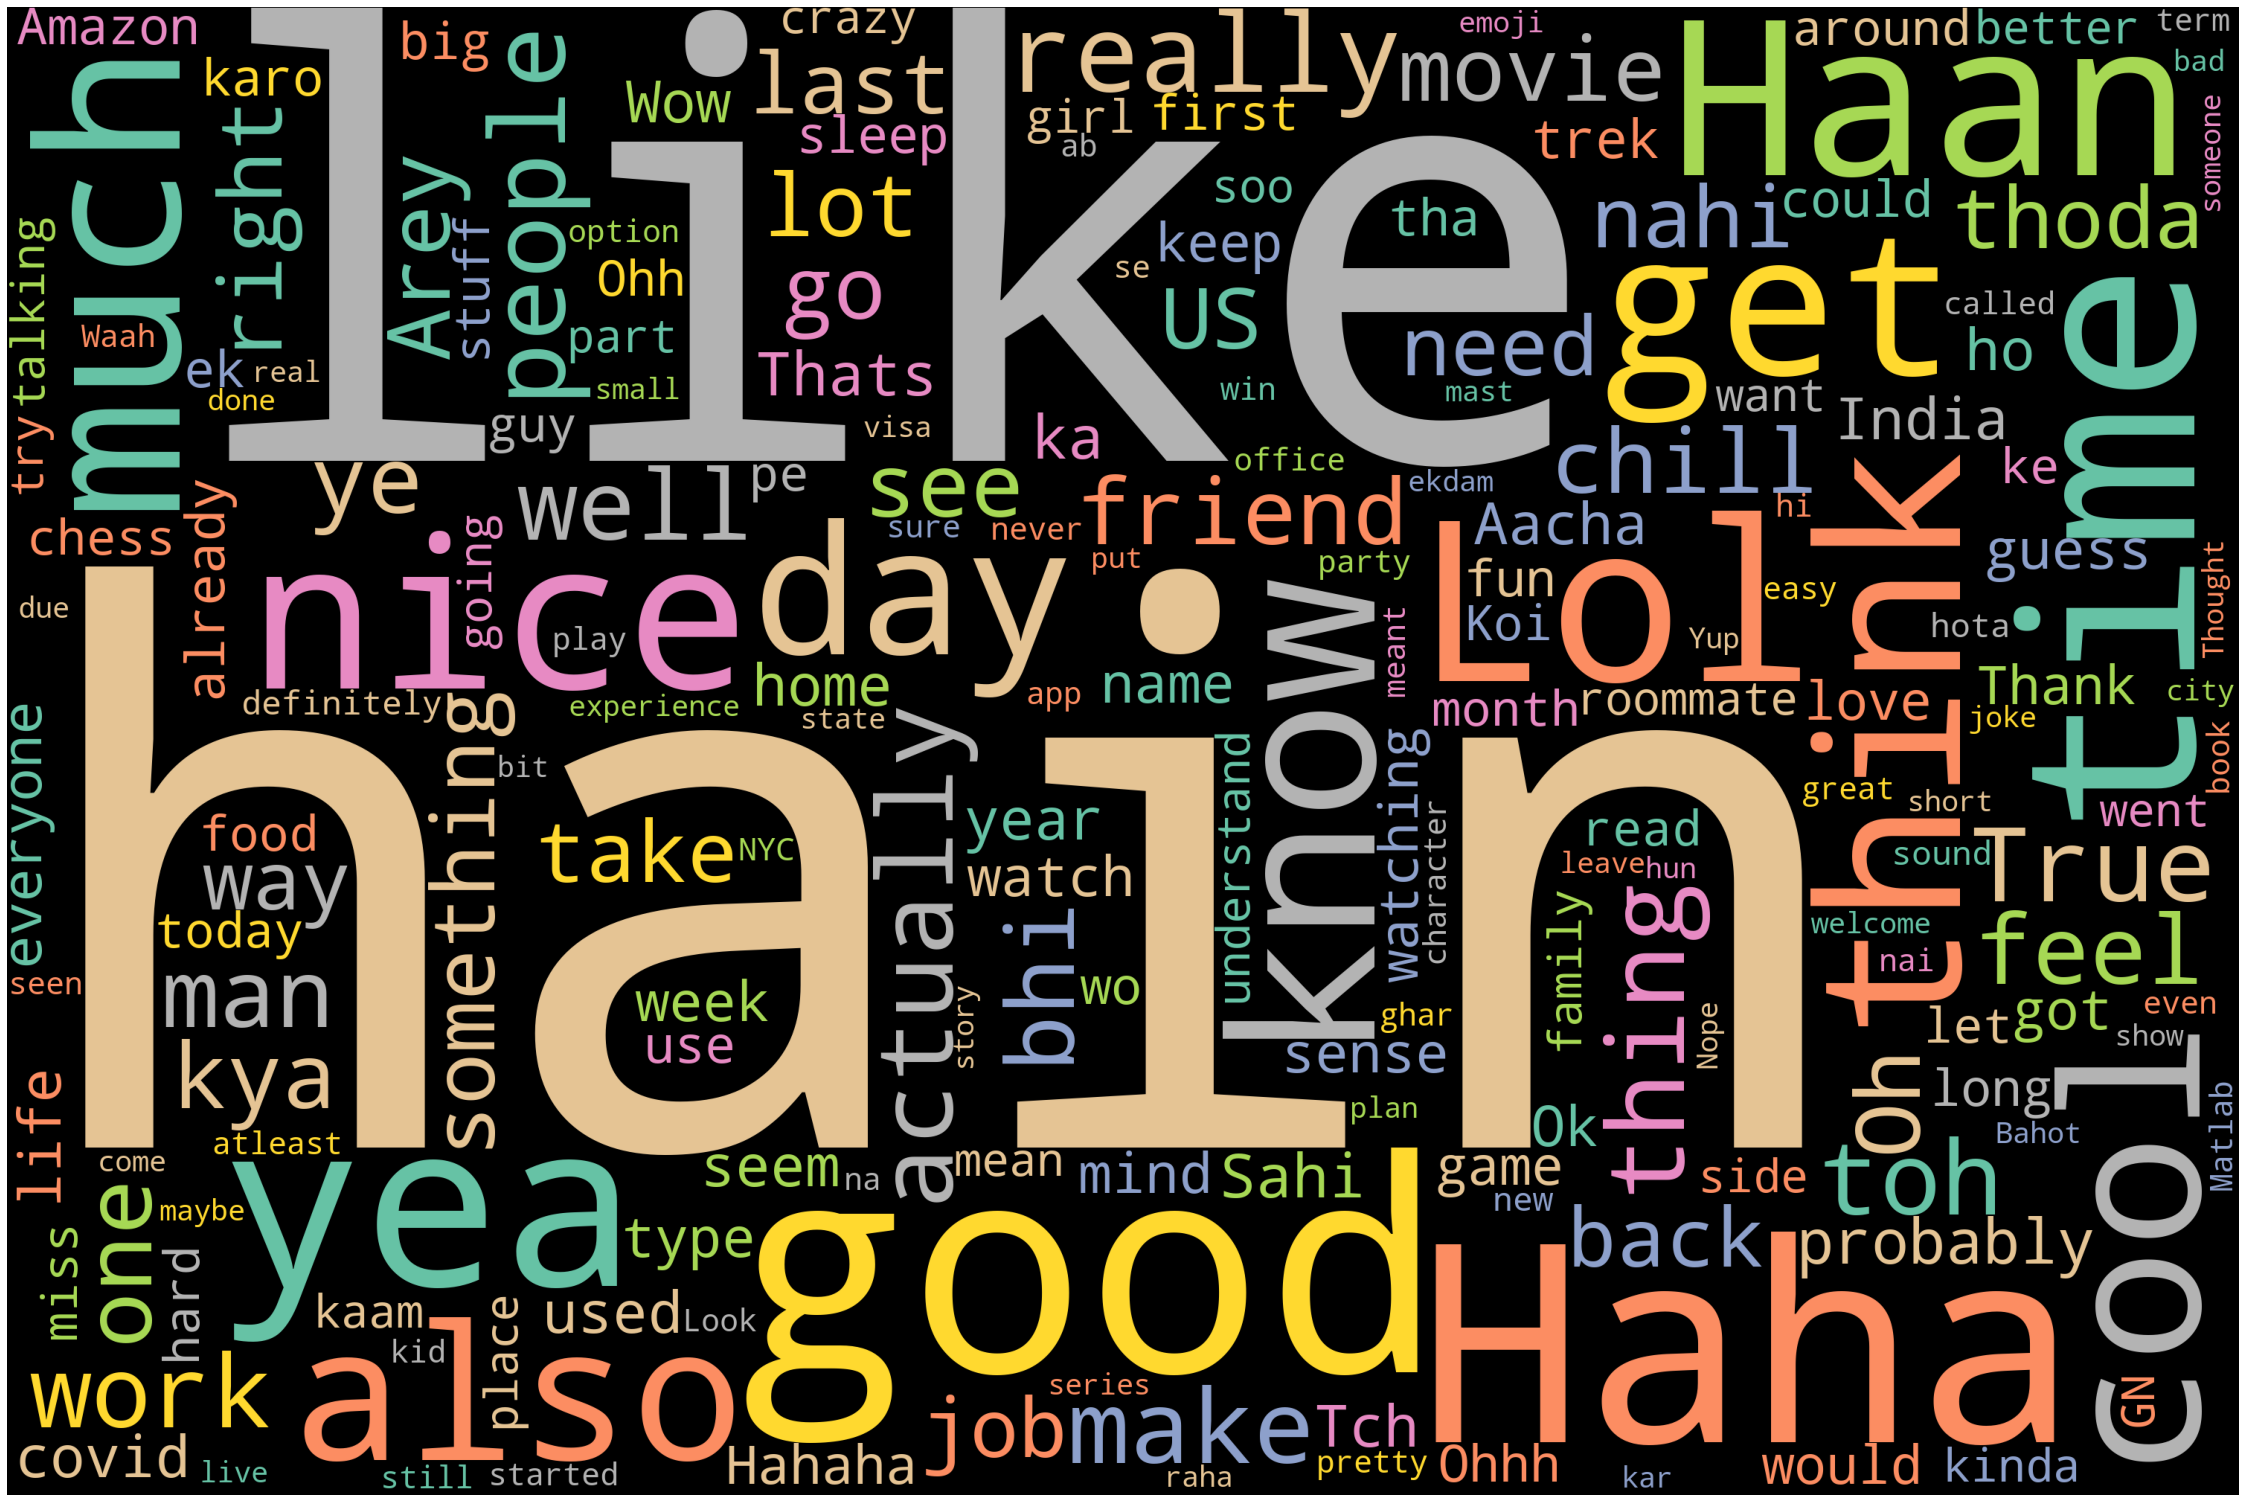

In [18]:
word_cloud_from_df(vk_data)

In [19]:
total_emojis_list = list(set([a for b in chat.emoji for a in b]))

total_emojis = len(total_emojis_list)

print('Sum of all unique used Emojis', total_emojis)

Sum of all unique used Emojis 88


In [20]:
total_emojis_list = list([a for b in chat.emoji for a in b])
emoji_dict = dict(Counter(total_emojis_list))
emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
emoji_df.head(10)

emoji  count
0      😂    475
1      😅    304
2      😛    222
3      🙈    166
4      🤭    102
5      🤓     72
6      😐     65
7  🤷🏻‍♀️     63
8  💁🏻‍♀️     43
9      🥺     42

In [ ]:
fig = px.treemap(emoji_df, path= ['emoji'],
    values = emoji_df['count'].tolist(),
)
fig.update_layout(uniformtext=dict(minsize=30, mode='show'))
fig.update_layout(title_text='Total Emojis')
fig.show()

![alt text](images/total_emoji.png "Title")

In [21]:
am_data = chat[chat['Author']=='AM']
vk_data = chat[chat['Author']=='VK']

In [ ]:
total_emojis_list = list([a for b in am_data.emoji for a in b])
emoji_dict = dict(Counter(total_emojis_list))
emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
emoji_df.head(10)

fig = px.treemap(emoji_df, path= ['emoji'],
    values = emoji_df['count'].tolist(),
)
fig.update_layout(uniformtext=dict(minsize=30, mode='show'))
fig.update_layout(title_text='Total Emojis: AM')
fig.show()

![alt text](images/am_emoji.png "Title")

In [ ]:
total_emojis_list = list([a for b in vk_data.emoji for a in b])
emoji_dict = dict(Counter(total_emojis_list))
emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
emoji_df.head(10)

fig = px.treemap(emoji_df, path= ['emoji'],
    values = emoji_df['count'].tolist(),
)
fig.update_layout(uniformtext=dict(minsize=30, mode='show'))
fig.update_layout(title_text='Total Emojis: VK')
fig.show()

![alt text](images/vk_emoji.png "Title")